<a href="https://colab.research.google.com/github/eszterurban/NLP/blob/main/beadand%C3%B3_NB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dalszöveg hangulat analizálás Naív Bayes modell építésével

# Installációk és importok



In [1]:
!pip install nltk

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download("wordnet")

from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = stopwords.words("english")

from nltk.corpus import wordnet as wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

import seaborn as sns
from matplotlib import pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Dataset beolvasás

In [3]:
import csv
import pandas as pd

file_path = 'labeled_lyrics_cleaned.csv'
rows = []


with open(file_path, 'r', encoding='utf-8', errors='ignore') as csvfile:
    csvreader = csv.reader(csvfile)

    for row in csvreader:
        rows.append(row)

dataset = pd.DataFrame(rows[1:], columns=rows[0])

In [4]:
dataset

,,artist,seq,song,label
0,0,Elijah Blake,"No, no\nI ain't ever trapped out the bando\nBu...",Everyday,0.626
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,0.63
2,2,Elijah Blake,She don't live on planet Earth no more\nShe fo...,The Otherside,0.24
3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,0.536
4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.371
...,...,...,...,...,...
158348,158348,Adam Green,"And we live on borrowed time,\nBut this headsh...",Friends of Mine,0.737
158349,158349,Adam Green,Frozin in time forever\nCarrying that torch fo...,Frozen in Time,0.482
158350,158350,Adam Green,Hard to be a girl. \nSo nice to be a boy. \nIn...,Hard to Be a Girl,0.733
158351,158351,Adam Green,"I want to chose to die,\nAnd be buried with a ...",I Wanna Die,0.361


# Label átalakítása szöveges formába

In [5]:
def map_to_sentiment_label(label):
    if label < 0.2:
        return "Very Negative"
    elif label < 0.4:
        return "Negative"
    elif label < 0.6:
        return "Neutral"
    elif label < 0.8:
        return "Positive"
    else:
        return "Very Positive"

In [6]:
example_labels = dataset["label"].astype(float).tolist()
mapped_sentiment_labels = [map_to_sentiment_label(label) for label in example_labels]

In [7]:
dataset["label"] = mapped_sentiment_labels

In [8]:
dataset.head()

,,artist,seq,song,label
0,0,Elijah Blake,"No, no\nI ain't ever trapped out the bando\nBu...",Everyday,Positive
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,Positive
2,2,Elijah Blake,She don't live on planet Earth no more\nShe fo...,The Otherside,Negative
3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,Neutral
4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,Negative


# Dataset lekicsinyítése

In [9]:
dataset = dataset.drop(columns=['artist', 'song'])

In [10]:
dataset.head()

,,seq,label
0,0,"No, no\nI ain't ever trapped out the bando\nBu...",Positive
1,1,"The drinks go down and smoke goes up, I feel m...",Positive
2,2,She don't live on planet Earth no more\nShe fo...,Negative
3,3,"Trippin' off that Grigio, mobbin', lights low\...",Neutral
4,4,"I see a midnight panther, so gallant and so br...",Negative


# Lemmantizálás

In [11]:
lemmatizer = WordNetLemmatizer()
tag_dictionary = {"J": wordnet.ADJ,
                  "N": wordnet.NOUN,
                  "V": wordnet.VERB,
                  "R": wordnet.ADV}

# Tokenizálás

In [12]:
def tokenize_sentence(sentence):
    return word_tokenize(sentence)

def extract_wnpostag_from_postag(tag):
    return tag_dictionary.get(tag[0].upper(), None)

def lemmatize_tupla_word_postag(_tuple):
    tag = extract_wnpostag_from_postag(_tuple[1])
    return lemmatizer.lemmatize(_tuple[0], tag) if tag is not None else _tuple[0]

def preprocess(sentence):
    lowercase_sentence = sentence.lower()

    tokenized_sentence = tokenize_sentence(lowercase_sentence)

    pos_tagged_words = nltk.pos_tag(tokenized_sentence)

    lemmatized_words = [ lemmatize_tupla_word_postag(ow) for ow in pos_tagged_words ]

    cleaned_words = [ w for w in lemmatized_words if (w.isalpha()) and (w not in STOPWORDS) ]

    return cleaned_words

In [13]:
dataset["seq"] = dataset["seq"].apply(preprocess)

In [14]:
dataset.head()

,,seq,label
0,0,"[ai, ever, trap, bando, oh, lord, get, wrong, ...",Positive
1,1,"[drink, go, smoke, go, feel, get, let, go, car...",Positive
2,2,"[live, planet, earth, find, love, venus, word,...",Negative
3,3,"[trippin, grigio, mobbin, light, low, trippin,...",Neutral
4,4,"[see, midnight, panther, gallant, brave, find,...",Negative


# Tanuló és elemző halmazok létrehozása

In [15]:
small_train_dataset = dataset[0:100000]
small_eval_dataset = dataset[100000:140000]

In [16]:
small_train_dataset = small_train_dataset.sample(frac=1)
small_eval_dataset = small_eval_dataset.sample(frac=1)

In [17]:
small_train_dataset, small_eval_dataset

(                                                            seq          label
 63583  63583  [moonray, cast, spell, upon, lover, starlit, c...        Neutral
 51317  51317  [give, yeah, like, want, settel, juggle, every...       Positive
 70352  70352  [often, walk, street, pavement, always, stay, ...       Positive
 81758  81758  [ca, stop, sun, come, come, come, get, hairdry...  Very Positive
 75740  75740  [shame, shame, perfect, shame, creep, door, oh...        Neutral
 ...      ...                                                ...            ...
 73999  73999  [like, lip, like, like, yeah, oh, pop, fizz, l...  Very Positive
 96870  96870  [matter, color, guilty, one, care, one, care, ...       Positive
 27955  27955  [swing, bangle, main, street, store, meet, dan...  Very Negative
 95277  95277  [open, door, adjust, eye, concrete, street, gr...        Neutral
 2835    2835  [everything, need, everything, us, nothing, le...        Neutral
 
 [100000 rows x 3 columns],
          

# Szótárat építünk

In [18]:
def dictionary_builder(input_rows, n):
    d = dict()

    for rows in input_rows:
        for token in rows:
            d[token] = d.get(token, 0) + 1

    return {k for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)[:n]}

In [19]:
dictionary = dictionary_builder(small_train_dataset["seq"].values, 10000)

In [20]:
lables = small_train_dataset["label"].unique()

# Gyakoriság vizsgálat

In [21]:
def frequency(df):
    freq = {lable: {} for lable in lables}

    for idx in range(df.shape[0]):
        tokens =df.iloc[idx, 1]
        lable = df.iloc[idx, 2]

        for token in tokens:
            if token in dictionary:
                freq[lable][token] = freq[lable].get(token, 0) + 1

    return freq

In [22]:
frequency_table = frequency(small_train_dataset)

# Cimkéhez tartozó gyakoriság

In [24]:
def extract_features(frequency_table, tokens):
    label_frequencies = {label: 0 for label in lables}

    for t in tokens:
        for lable in lables:
            label_frequencies[lable] += frequency_table[lable].get(t, 0)

    return pd.Series(label_frequencies)

In [25]:
X_train = small_train_dataset["seq"].apply(lambda tokens: extract_features(frequency_table, tokens))
X_train
y_train = small_train_dataset["label"].values
y_train

array(['Neutral', 'Positive', 'Positive', ..., 'Very Negative', 'Neutral',
       'Neutral'], dtype=object)

# Naív Bayes modell megépítése

In [26]:
model = MultinomialNB(alpha=1)

In [27]:
model.fit(X_train.values,y_train)

MultinomialNB(alpha=1)

In [28]:
X_eval = small_eval_dataset["seq"].apply(lambda tokens: extract_features(frequency_table, tokens))
y_eval = small_eval_dataset["label"].values

In [29]:
eval_pred = model.predict(X_eval)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(


# Kirajzoljuk a hőtérképen hogy hogyan tudja megprediktálni a modell a labelt

Text(50.722222222222214, 0.5, 'Real lable')

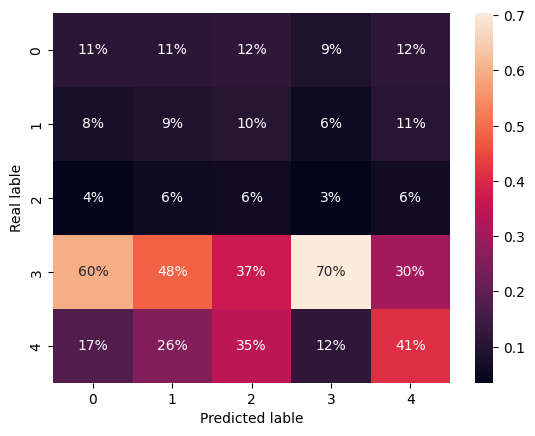

In [30]:
matrix = confusion_matrix(y_eval, eval_pred, normalize="true")

sns.heatmap(matrix.T, annot=True, fmt=".0%")
plt.xlabel("Predicted lable")
plt.ylabel("Real lable")